### Exploratory Data Analysis

Before modeling, let's explore the data to see how many images we have and how many faces we have to build our model with. Next we will create a dataframe for easier image reference. Then we will check a few images with annotations to make sure they are reading in correctly.

In [1]:
# import the necessary packages
import pathlib
import matplotlib.pyplot as plt
import numpy as np
import os
import glob
import cv2
import xml.etree.ElementTree as et
import pandas as pd

In [2]:
# create file paths for easy reference
image_path= pathlib.Path('/Users/claireph/DSI/Submissions/projects/capstone/data/images')
annot_path = pathlib.Path('/Users/claireph/DSI/Submissions/projects/capstone/data/annotations/')
image_directories = sorted(glob.glob(os.path.join(image_path,"*.png")))
label_directories = sorted(glob.glob(os.path.join(annot_path, "*.xml")))

In [3]:
# maximum number of objects will determine columns needed for dataframe
face_count = []
for file in os.listdir(annot_path):
    xml = et.parse(os.path.join(annot_path, file)) 
    root = xml.getroot()
    face_count.append(len(root) - 4)

print("Total number of images: ", len(os.listdir(annot_path)))
print("Maximum # of objects per image: ", max(face_count))
print("Average # of objects per image: ", round(np.mean(face_count),1))

Total number of images:  853
Maximum # of objects per image:  115
Average # of objects per image:  4.8


In [4]:
# check total number of labels per class
label_dict = {'with_mask': 0, 'without_mask': 0, 'mask_weared_incorrect': 0}

for file in os.listdir(annot_path):

    xml = et.parse(os.path.join(annot_path, file)) 
    root = xml.getroot()    

    for i in range(4,len(root)):
        label_dict[root[i][0].text] += 1

print("Faces with mask: ", label_dict['with_mask'])
print("Faces without mask: ", label_dict['without_mask'])
print("Faces with mask worn incorrectly: ", label_dict['mask_weared_incorrect'])

Faces with mask:  3232
Faces without mask:  717
Faces with mask worn incorrectly:  123


In [5]:
# reference: https://docs.python.org/3/library/xml.etree.elementtree.html
# Creating a dictionary that can be used in a dataframe
image_dict = {"image": [],"Dimensions": [], "face_count": []}
# 115 is the max number of faces per image
for i in range(1,116):
    image_dict[f'Object {i}']=[]

# loop through annotation files to parse object information
for file in sorted(os.listdir(annot_path)):
    row = []
    xml = et.parse(os.path.join(annot_path, file)) 
    root = xml.getroot()
    # extract image name and add to start of row
    img = root[1].text
    row.append(img)
    # extract image dimensions
    h,w = root[2][0].text,root[2][1].text
    row.append([h,w])
    face_ct = len(root) - 4
    row.append(face_ct)
    
    
    # add column to each row for each object (face). Objects start at the 4th element
    for i in range(4,len(root)):
        temp = []
        # object label - with_mask, without_mask, or mask_weared_incorrect
        temp.append(root[i][0].text)
        # bounding box dimensions
        for point in root[i][5]:
            temp.append(point.text)
        row.append(temp)
    # after appending all objects to row, add a 0 for remainder
    for i in range(len(row),119):
        row.append(0)
        
    # add all elements to the dictionary
    for i,each in enumerate(image_dict):
        image_dict[each].append(row[i])
df = pd.DataFrame(image_dict)

In [6]:
df.head()

,image,Dimensions,face_count,Object 1,Object 2,Object 3,Object 4,Object 5,Object 6,Object 7,...,Object 106,Object 107,Object 108,Object 109,Object 110,Object 111,Object 112,Object 113,Object 114,Object 115
0,maksssksksss0.png,"[512, 366]",3,"[without_mask, 79, 105, 109, 142]","[with_mask, 185, 100, 226, 144]","[without_mask, 325, 90, 360, 141]",0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,maksssksksss1.png,"[400, 156]",9,"[with_mask, 321, 34, 354, 69]","[with_mask, 224, 38, 261, 73]","[with_mask, 299, 58, 315, 81]","[with_mask, 143, 74, 174, 115]","[with_mask, 74, 69, 95, 99]","[with_mask, 191, 67, 221, 93]","[with_mask, 21, 73, 44, 93]",...,0,0,0,0,0,0,0,0,0,0
2,maksssksksss10.png,"[301, 400]",1,"[with_mask, 98, 267, 194, 383]",0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,maksssksksss100.png,"[400, 226]",3,"[with_mask, 189, 30, 245, 88]","[with_mask, 387, 54, 400, 75]","[with_mask, 118, 87, 163, 126]",0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,maksssksksss101.png,"[301, 400]",1,"[with_mask, 48, 294, 164, 400]",0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [7]:
def show_annotated_image(image):
    
    """This function adds annotation labels and bounding boxes to each image
    so that we can display ground truth images with annotations"""
    
    row = df[df['image'] == image]
    idx = row.index
    
    new_image_path = os.path.join(image_path,image)
    
    original_image = cv2.imread(new_image_path)
    
    for obj in row.columns[3:]:
        info = row[obj][idx]
        if info.any():
            label_name = info.iloc[0][0]
            coordinates = info.iloc[0][1:]

            if label_name == 'with_mask':
                label = 'with_mask'
                color = (0, 255, 0)
            elif label_name == 'without_mask':
                label = 'without_mask'
                color = (0, 0, 255)
            else:
                label = 'mask_worn_incorrectly'
                color = (255, 0, 0)
            
            coordinates = [int(pt) for pt in coordinates]

            cv2.rectangle(
                original_image,
                (coordinates[0], coordinates[1]),
                (coordinates[2], coordinates[3]),
                color,
                2
            )
            cv2.putText(original_image, label, (coordinates[0], coordinates[1] - 10),
                cv2.FONT_HERSHEY_SIMPLEX, 0.45, color, 2)
    plt.imshow(cv2.cvtColor(original_image, cv2.COLOR_BGR2RGB)) 
    plt.grid(None)

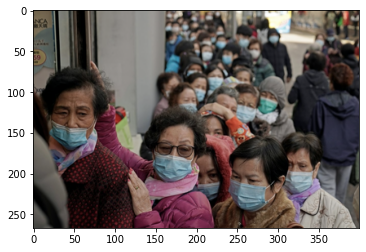

In [8]:
# display original image
test_image_path = os.path.join(image_path,'maksssksksss11.png')
test_image = cv2.imread(test_image_path)
plt.imshow(cv2.cvtColor(test_image, cv2.COLOR_BGR2RGB));

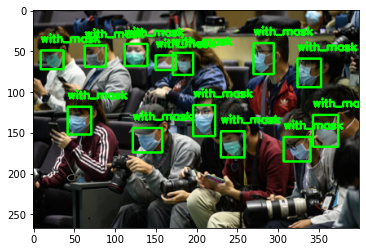

In [9]:
# display annotated image
show_annotated_image('maksssksksss247.png')
plt.grid(None)

In [10]:
# pickle the image dataframe for future reference
df.to_pickle('image_df.pkl')